In [ ]:
# ================================================
# STEP 1 — Install Kaggle & Upload kaggle.json
# ================================================
!pip install kaggle

from google.colab import files
files.upload()  # upload kaggle.json

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# ================================================
# STEP 2 — Download Dataset (90 Animals)
# ================================================
!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals
!unzip animal-image-dataset-90-different-animals.zip -d animal90


Streaming output truncated to the last 5000 lines.
  inflating: animal90/animals/animals/bison/73b10839bc.jpg  
  inflating: animal90/animals/animals/bison/74dc1dd32a.jpg  
  inflating: animal90/animals/animals/bison/75ab166a7d.jpg  
  inflating: animal90/animals/animals/bison/79e1610d01.jpg  
  inflating: animal90/animals/animals/bison/7ba5eee91f.jpg  
  inflating: animal90/animals/animals/bison/7d214aab4b.jpg  
  inflating: animal90/animals/animals/bison/7f2ef9ab03.jpg  
  inflating: animal90/animals/animals/bison/82ec723a4f.jpg  
  inflating: animal90/animals/animals/bison/85e145af6c.jpg  
  inflating: animal90/animals/animals/bison/862e2c6379.jpg  
  inflating: animal90/animals/animals/bison/87a5c700ad.jpg  
  inflating: animal90/animals/animals/bison/88b723ce90.jpg  
  inflating: animal90/animals/animals/bison/8c3af742c3.jpg  
  inflating: animal90/animals/animals/bison/8e34044b98.jpg  
  inflating: animal90/animals/animals/bison/8e6adbdc40.jpg  
  inflating: animal90/animals/anim

In [ ]:
# ================================================
# STEP 3 — Split dataset into train/val/test
# ================================================
!pip install split-folders
import splitfolders

splitfolders.ratio(
    "/content/animal90/animals/animals",   # correct path
    output="/content/animal90_split",
    seed=42,
    ratio=(0.8, 0.1, 0.1)
)


Copying files: 5400 files [00:04, 1265.50 files/s]


In [ ]:
# ================================================
# STEP 4 — Create Data Generators
# ================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (160, 160)   # smaller = faster training
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    "/content/animal90_split/train",
    target_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = val_gen.flow_from_directory(
    "/content/animal90_split/val",
    target_size=img_size,
    batch_size=batch_size
)

class_names = list(train_ds.class_indices.keys())
print("Total classes:", len(class_names))


Found 4320 images belonging to 90 classes.
Found 540 images belonging to 90 classes.
Total classes: 90


In [ ]:
# ================================================
# STEP 5 — Build FAST MobileNetV2 Model
# ================================================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

base = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(160,160,3)
)
base.trainable = False   # Freeze backbone

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │       115,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,373,274 (9.05 MB)

 Trainable params: 115,290 (450.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ================================================
# STEP 6 — Train (Fast)
# ================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2162 - loss: 3.6398 - val_accuracy: 0.7352 - val_loss: 1.0753
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7357 - loss: 1.0534 - val_accuracy: 0.7907 - val_loss: 0.7659
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8173 - loss: 0.7104 - val_accuracy: 0.8259 - val_loss: 0.6899
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8318 - loss: 0.5957 - val_accuracy: 0.8370 - val_loss: 0.6211
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8702 - loss: 0.4473 - val_accuracy: 0.8389 - val_loss: 0.6114
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8953 - loss: 0.3783 - val_accuracy: 0.8444 - val_loss: 0.5929
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9085 - loss: 0.3370 - val_accuracy: 0.8593 - val_loss: 0.5636
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9272 - loss: 0.2767 - val_accuracy: 0.

In [ ]:
# ================================================
# STEP 7 — Fine-Tune (Optional but improves accuracy)
# ================================================
base.trainable = True

# Unfreeze last 30 layers
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8214 - loss: 0.6373 - val_accuracy: 0.8556 - val_loss: 0.5476
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8658 - loss: 0.4830 - val_accuracy: 0.8556 - val_loss: 0.5458
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8762 - loss: 0.4313 - val_accuracy: 0.8556 - val_loss: 0.5444
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9038 - loss: 0.3670 - val_accuracy: 0.8556 - val_loss: 0.5465
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8987 - loss: 0.3773 - val_accuracy: 0.8537 - val_loss: 0.5486


In [ ]:
# ================================================
# STEP 8 — Save Model + Class Names
# ================================================
model.save("animal90_model.h5")

import json
with open("animal90_classes.json", "w") as f:
    json.dump(class_names, f)

print("Model and class names saved successfully!")


Model and class names saved successfully!


In [ ]:
# ================================================
# STEP 9 — Load Model Later (Optional)
# ================================================
import tensorflow as tf
from tensorflow.keras.models import load_model
import json

model = load_model("animal90_model.h5")

with open("animal90_classes.json", "r") as f:
    class_names = json.load(f)

print("Model loaded successfully!")


Model loaded successfully!


Saving 1443.jpg to 1443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


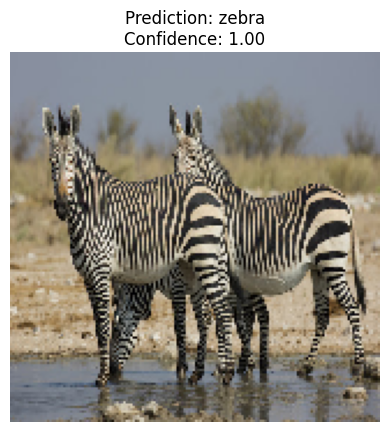

Detected: zebra (Confidence: 1.00)


In [ ]:
# ================================================
# STEP 10 — Predict Animal from Uploaded Image
# ================================================
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    img = image.load_img(fn, target_size=img_size)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0) / 255.0

    preds = model.predict(arr)[0]
    idx = np.argmax(preds)
    label = class_names[idx]
    confidence = preds[idx]

    plt.imshow(img)
    plt.title(f"Prediction: {label}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    print(f"Detected: {label} (Confidence: {confidence:.2f})")


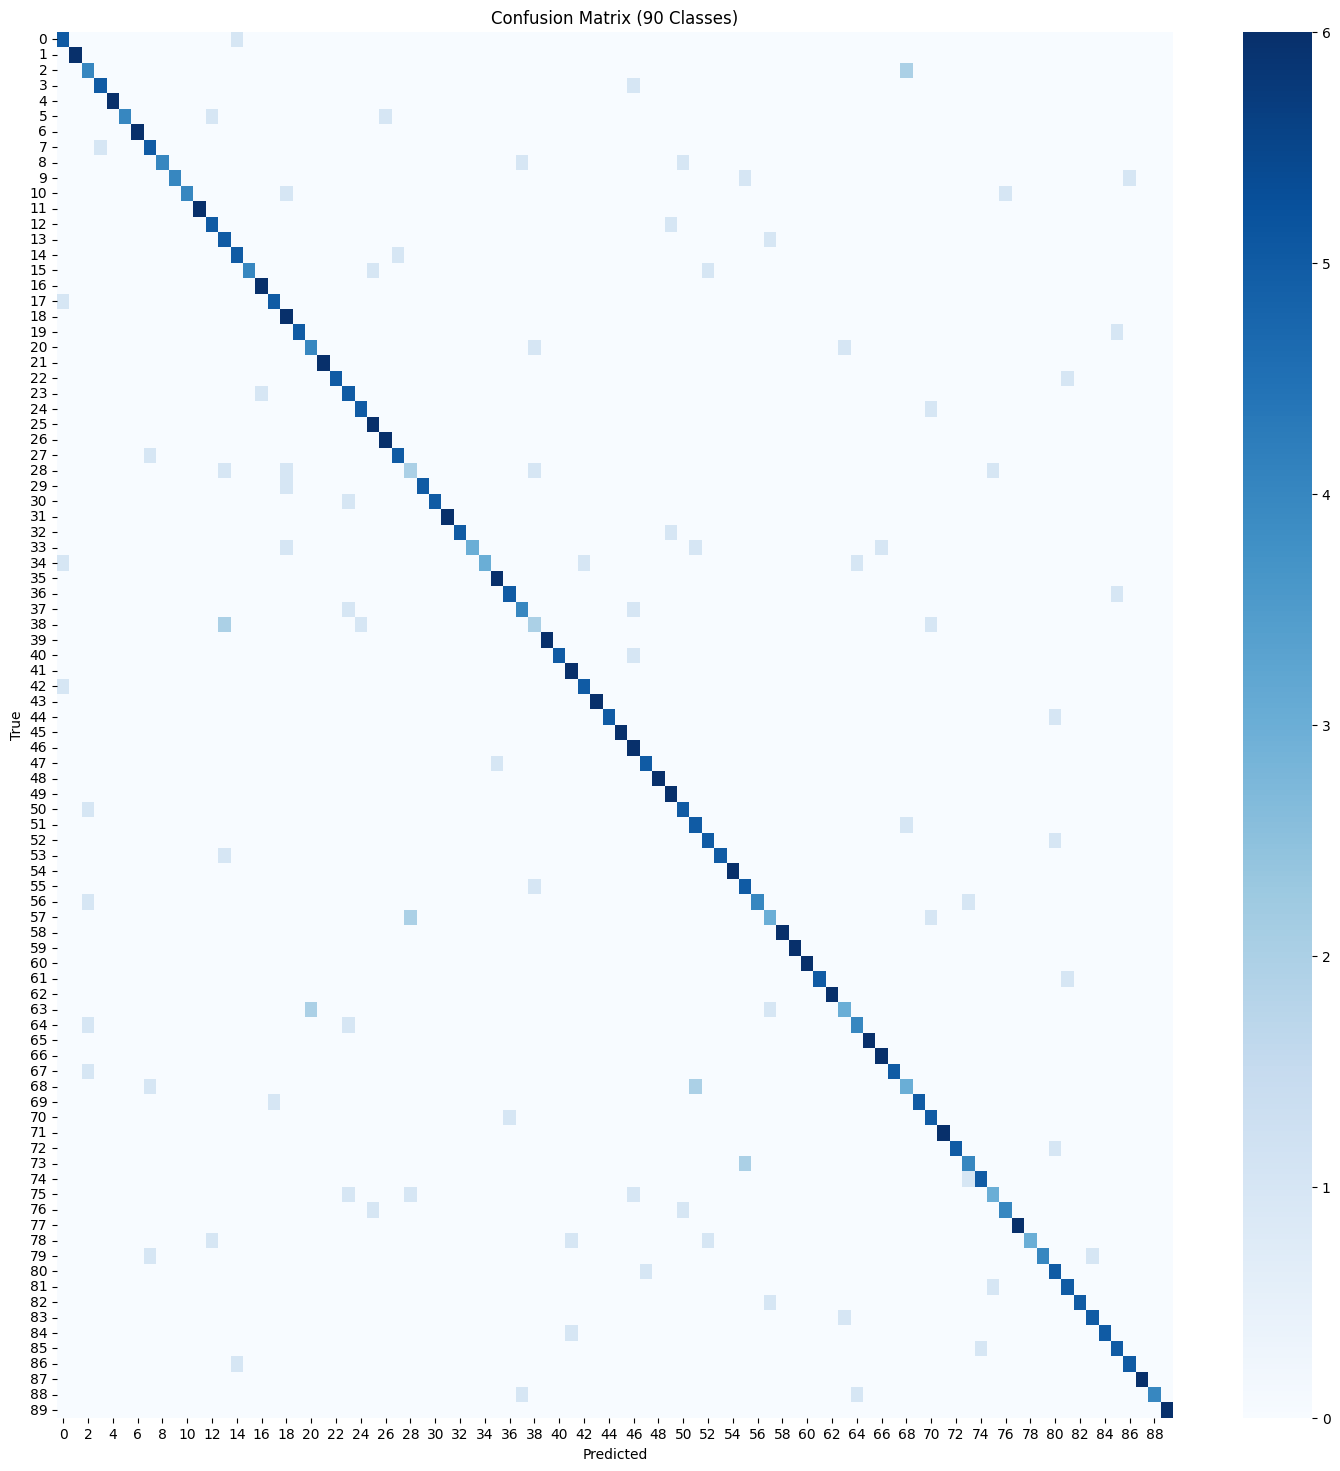

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(18, 18))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix (90 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)


                precision    recall  f1-score   support

      antelope       0.62      0.83      0.71         6
        badger       1.00      1.00      1.00         6
           bat       0.50      0.67      0.57         6
          bear       0.83      0.83      0.83         6
           bee       1.00      1.00      1.00         6
        beetle       1.00      0.67      0.80         6
         bison       1.00      1.00      1.00         6
          boar       0.62      0.83      0.71         6
     butterfly       1.00      0.67      0.80         6
           cat       1.00      0.67      0.80         6
   caterpillar       1.00      0.67      0.80         6
    chimpanzee       1.00      1.00      1.00         6
     cockroach       0.71      0.83      0.77         6
           cow       0.56      0.83      0.67         6
        coyote       0.71      0.83      0.77         6
          crab       1.00      0.67      0.80         6
          crow       0.86      1.00      0.92  

In [ ]:
import numpy as np

errors = np.where(pred_labels != true_labels)[0]
print("Total Misclassified:", len(errors))


Total Misclassified: 95


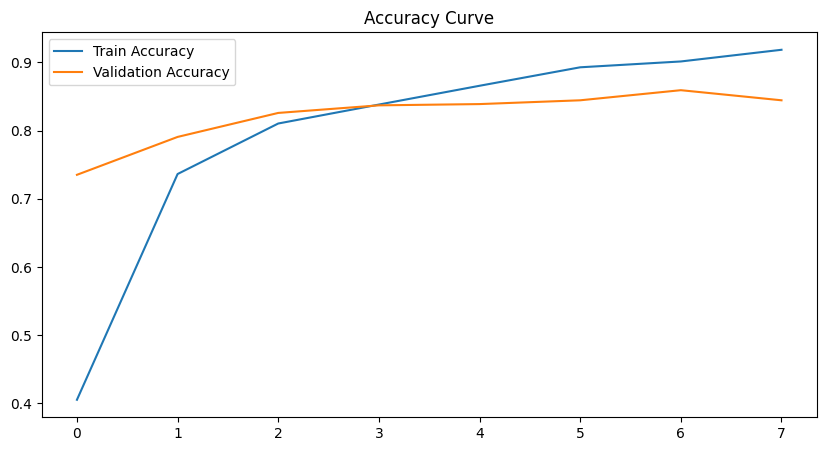

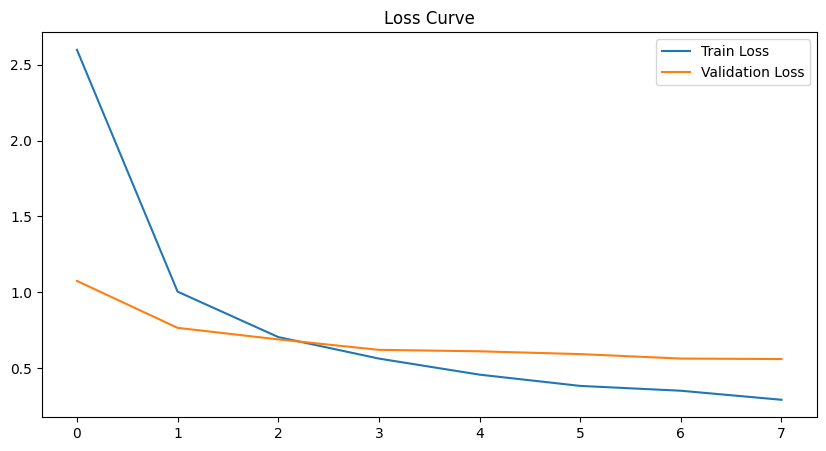

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


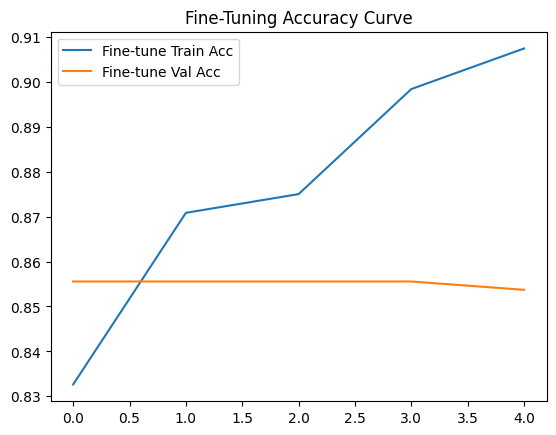

In [ ]:
plt.plot(history_fine.history['accuracy'], label='Fine-tune Train Acc')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tune Val Acc')
plt.legend()
plt.title("Fine-Tuning Accuracy Curve")
plt.show()


In [ ]:
!find /content/animal90/animals/animals -type f | wc -l


5400
